# Copyright
<pre>
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved

</pre>

In this notebook, we will classify human activities based on smartphone accelerometer and gyroscope data. The corresponding Human Activity Recognition Using Smartphones Data Set is delivered by UCI Machine Learning Repository, for more information [please visit the site](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

## 1. Data acquisition
Lets download and unpack the data.

In [32]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

--2024-04-10 21:29:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip.1’

UCI HAR Dataset.zip     [         <=>        ]  58.17M  1.22MB/s    in 40s     

2024-04-10 21:30:19 (1.46 MB/s) - ‘UCI HAR Dataset.zip.1’ saved [60999314]



In [34]:
!unzip "UCI HAR Dataset.zip" > null

replace UCI HAR Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 2. Imports
In this notebook we will need the following packages.

In [35]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Loading the data
The following functions will load the training and test data from the unpacked dataset.

In [36]:
# this function loads a single file (input or output)
def load_file(filepath):
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
  return df.values

# this function loads a set of files into a Numpy array with a shape of [samples, timesteps, features]
def load_group(filenames, prefix=''):
  loaded = list()
  for name in filenames:
    data = load_file(prefix + name)
    loaded.append(data)
    # stack group so that features are the 3rd dimension
  loaded = np.dstack(loaded)
  return loaded

 # load inputs and outputs from a directory
def load_XY(group, path):
  filepath = path + group + '/Inertial Signals/'
  filenames = list()
  filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt'] + \
               ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt'] + \
               ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
  # inputs
  X = load_group(filenames, filepath)
  # output (class)
  Y = load_file(path + group + '/y_'+group+'.txt')
  return X, Y

# load the dataset, returns train and test X and y elements
def load_dataset(path='UCI HAR Dataset/'):
  # load all train
  X_train, Y_train = load_XY('train', path)
  X_test,  Y_test  = load_XY('test', path)
  Y_train = to_categorical(Y_train - 1 ) # we need -1 to scale the categories between 0..5 (from 1..6)
  Y_test  = to_categorical(Y_test - 1 ) # we need -1 to scale the categories between 0..5 (from 1..6)
  return X_train, Y_train, X_test, Y_test

In [37]:
X_train, Y_train, X_test, Y_test = load_dataset()

In [38]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((7352, 128, 9), (7352, 6), (2947, 128, 9), (2947, 6))

In [39]:
Y_train[0],

(array([0., 0., 0., 0., 1., 0.], dtype=float32),)

## 3.1. Data exploration: target variable - exercise 1
Let's check how many data instances there are for each class:

In [40]:
print("No. of instance belong to class 0:", len(Y_train[Y_train[:, 0] == 1]))
print("No. of instance belong to class 1:", len(Y_train[Y_train[:, 1] == 1]))
print("No. of instance belong to class 2:", len(Y_train[Y_train[:, 2] == 1]))
print("No. of instance belong to class 3:", len(Y_train[Y_train[:, 3] == 1]))
print("No. of instance belong to class 4:", len(Y_train[Y_train[:, 4] == 1]))
print("No. of instance belong to class 5:", len(Y_train[Y_train[:, 5] == 1]))

No. of instance belong to class 0: 1226
No. of instance belong to class 1: 1073
No. of instance belong to class 2: 986
No. of instance belong to class 3: 1286
No. of instance belong to class 4: 1374
No. of instance belong to class 5: 1407


You can doublecheck your calculations by plotting the histogram of the target variables:

<Axes: ylabel='Count'>

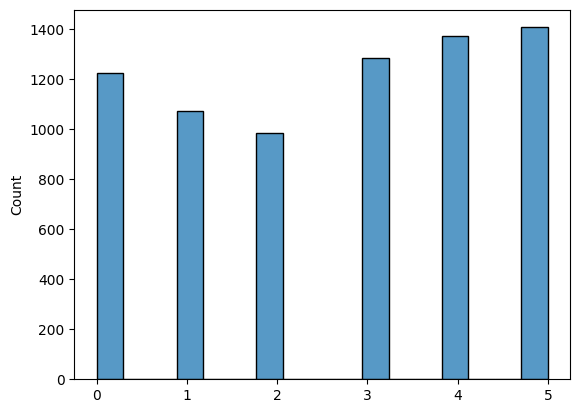

In [41]:
sns.histplot(np.argmax(Y_train,axis=1))

## 3.2. Data exploration: input variables - exercise 2
And now let's select one instance from each class and plot the corresponding timeseries:

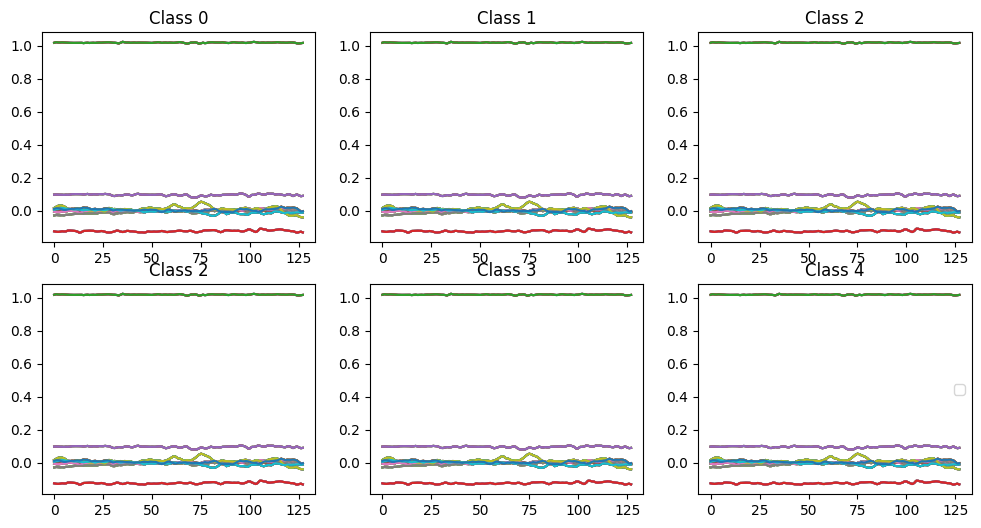

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i in range(2): # row
  for k in range(3): # column
    for l in range(X_train.shape[2]): # dimensons to be displayed
      class_no=i*2+k
      axs[i,k].plot(X_train[1])
      axs[i,k].title.set_text("Class "+str(class_no))
plt.legend()

## 4. Model definition and training - exercise 3

Let's define and train a 1D convolutional neural network, with the multidimensional timeseries as inputs, and the class in one-hot encoding as output.

This time your task is to correct the code below and achieve higher than 90% validation accuracy and test accuracy. The test accuracy is calculated in section 5.
Currently, **there are many errors (both syntactical and theroetical) in the model definition, compile and fit parts**, that should be fixed to achieve the goal. Don't change the number of layers and the layer types, and validation_split, just the other hyperparameters. There are several good solutions!

Hints:
* use narrow and deep Conv1D kernels
* use standard activation functions for the inner layers (e.g. relu, sigmoid, tanh) with the corresponding initialization method
* use the appropriate activation function the output and the corresponding loss function (which is aligned with the classification task)
* use regularization, but not too agressive
* use standard optimizers
* train in mini-batches

In [46]:
nb_filter       = 64   # number of filter/kernels in the convolutional layers
filter_length   = 3  # length of the filter/kernel in the convolutional layers
window_size     = X_train.shape[1] # the window size defined by the dataset
nb_features     = X_train.shape[2] # the number of features of the input data
nb_outputs      = Y_train.shape[1] # the number of outputs (defined by the target data)

from keras.initializers import lecun_normal
from keras.activations import selu

In [47]:
model = Sequential()
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation=selu, kernel_initializer=lecun_normal(), input_shape=(window_size, nb_features)))
model.add(MaxPooling1D())
model.add(Dropout(0.5))  # Reduced the dropout rate to 0.5 for better regularization
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation=selu, kernel_initializer=lecun_normal()))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation=selu))
model.add(Dropout(0.5))
model.add(Dense(nb_outputs, activation='softmax'))  # Using softmax activation for multi-class classification

Compiling the model with the appropriate loss function for multiclass classification.

In [51]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 63, 64)            0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 63, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 61, 64)            12352     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 30, 64)           

In [54]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

And now we run the training:

In [57]:
model.fit(X_train, Y_train,
          epochs=200, batch_size=8,
          validation_split=0.2, # don't change the validation split
          callbacks=[es],
          verbose=2)

Epoch 1/200
736/736 - 7s - loss: 0.3209 - accuracy: 0.8976 - val_loss: 0.5654 - val_accuracy: 0.9143 - 7s/epoch - 10ms/step
Epoch 2/200
736/736 - 6s - loss: 0.2608 - accuracy: 0.9153 - val_loss: 0.6109 - val_accuracy: 0.9184 - 6s/epoch - 8ms/step
Epoch 3/200
736/736 - 5s - loss: 0.2569 - accuracy: 0.9172 - val_loss: 0.6879 - val_accuracy: 0.9171 - 5s/epoch - 7ms/step
Epoch 4/200
736/736 - 7s - loss: 0.2420 - accuracy: 0.9150 - val_loss: 0.5231 - val_accuracy: 0.9164 - 7s/epoch - 10ms/step
Epoch 5/200
736/736 - 5s - loss: 0.2345 - accuracy: 0.9169 - val_loss: 0.3864 - val_accuracy: 0.9327 - 5s/epoch - 7ms/step
Epoch 6/200
736/736 - 6s - loss: 0.2592 - accuracy: 0.9187 - val_loss: 0.3833 - val_accuracy: 0.9327 - 6s/epoch - 8ms/step
Epoch 7/200
736/736 - 5s - loss: 0.2654 - accuracy: 0.9129 - val_loss: 0.5753 - val_accuracy: 0.9279 - 5s/epoch - 7ms/step
Epoch 8/200
736/736 - 5s - loss: 0.2648 - accuracy: 0.9177 - val_loss: 0.7281 - val_accuracy: 0.9150 - 5s/epoch - 7ms/step
Epoch 9/200
73

## 5. Evaluation
Please run the cells below to check the test loss and test accuracy (remember, the accuracy must be over 90%) and inspect the other evaluation methods as well.

In [58]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

93/93 [==============================] - 1s 3ms/step - loss: 1.8747 - accuracy: 0.9050
Test loss: 1.8747062683105469
Test accuracy: 0.9049881100654602


In [59]:
from sklearn.metrics import confusion_matrix, classification_report

In [60]:
preds = model.predict(X_test)

93/93 [==============================] - 0s 2ms/step


In [61]:
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       496
           1       0.99      0.92      0.95       471
           2       0.90      0.98      0.94       420
           3       0.80      0.78      0.79       491
           4       0.83      0.82      0.83       532
           5       0.96      1.00      0.98       537

    accuracy                           0.90      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.90      0.90      2947



<Axes: >

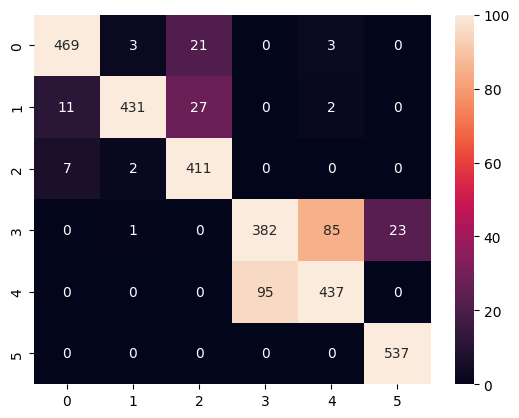

In [62]:
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)